# The Nature Conservancy Fisheries Monitoring

In [2]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
from scipy.special import softmax
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Conv2D, Input

In [3]:
# Constants
TRAIN_PREFIX = 'fisheries monitoring/train'
IMG_HEIGHT = 750
IMG_WIDTH = 1200
ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

### Загружаем разметку

In [5]:
def load_annotations():
    boxes, labels = {}, []
    for path in glob('fisheries monitoring/boxes/*.json'):
        fish_type = os.path.basename(path).split('_', 1)[0].upper()
        with open(path) as src:    
            for annotation in json.load(src):
                annotation['fish']=fish_type
                annotation['filename'] = os.path.join(TRAIN_PREFIX, fish_type,
                                                      os.path.basename(annotation['filename']))
                labels.append(fish_type)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(fish_type, []).append(annotation)
  
    return boxes, pd.get_dummies(labels, dtype=int).drop_duplicates()

In [6]:
def draw_boxes(annotation, rectangles=None, image_size=None):    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)       
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)  
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))
        
    return img

### Экстрактор признаков

In [7]:
# Feature extractor using VGG16
def create_feature_extractor():
    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    return base_model.output, base_model.input

In [8]:
# Building the model
def build_model(feature_tensor, input_tensor):
    bn = BatchNormalization()(feature_tensor)
    output_tensor = Conv2D(11, kernel_size=(1, 1), activation='linear', kernel_regularizer='l2')(bn)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

### Функция потерь

In [9]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    return K.binary_crossentropy(y_true[..., 0], y_pred[..., 0], from_logits=True)

def category_loss(y_true, y_pred):
    return K.categorical_crossentropy(y_true[..., 5:], y_pred[..., 5:], from_logits=True)

def smooth_l1_loss(y_true, y_pred):
    difference = y_true[..., 1:5] - y_pred[..., 1:5]
    abs_diff = K.abs(difference)
    squared_diff = K.square(difference)
    mask = K.cast(abs_diff < 1, 'float32')
    return K.sum(0.5 * squared_diff * mask + (abs_diff - 0.5) * (1 - mask), axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3, alpha=0.25, gamma=2.0):
    # Reshape the predictions and truths for easier manipulation
    batch_size = K.shape(y_true)[0]
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))

   # Calculate losses 
    conf_loss = confidence_loss(y_true, y_pred)
    cat_loss = category_loss(y_true, y_pred)
    loc_loss = smooth_l1_loss(y_true, y_pred)

    # Calculate positive and negative mask
    object_mask = y_true[..., 0] # confidence score
    no_object_mask = 1 - object_mask
    
    # Apply focal loss to the category loss
    focal_factor = K.pow((1 - y_pred[..., 0]), gamma)
    cat_loss = alpha * cat_loss * focal_factor * object_mask
    
    # Calculate total losses
    total_conf_loss = K.sum(conf_loss * no_object_mask) / (K.sum(no_object_mask) + 1e-6)
    total_cat_loss = K.sum(cat_loss) / (K.sum(object_mask) + 1e-6)
    total_loc_loss = K.sum(loc_loss * object_mask) / (K.sum(object_mask) + 1e-6)
    
    return total_conf_loss + total_cat_loss + total_loc_loss

### Загрузка данных

In [10]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

### Сетка якорей (anchor grid)

In [15]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [12]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale   
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = max(0, dx) * max(0, dy)   
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union if union != 0 else 0

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]

    y_cat = np.array(labels[annotation['fish']])
    
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh, y_cat[0], y_cat[1],
                                 y_cat[2], y_cat[3], y_cat[4], y_cat[5]]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            y_cat = np.empty(6)
            
            logit, dx, dy, dw, dh,y_cat[0],y_cat[1], y_cat[2], y_cat[3], y_cat[4], y_cat[5] = prediction[row, col]
            conf = _sigmoid(logit)
            y_cat = softmax(y_cat)
            
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf, 
                                   'label': np.argmax(_sigmoid(y_cat)),
                                   'labels': y_cat})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

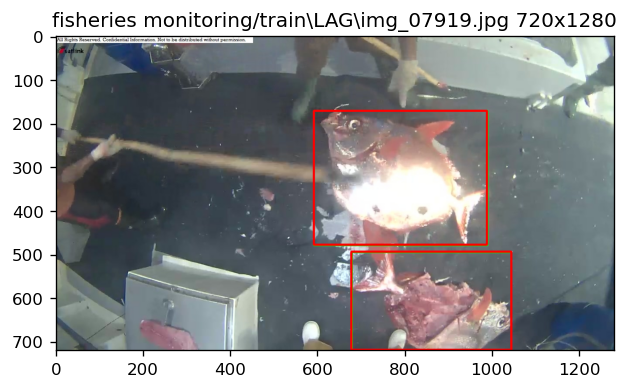

In [14]:
annotation = boxes['LAG'][0]
img = draw_boxes(annotation)

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Обучение

In [13]:
boxes, labels = load_annotations()

In [14]:
feature_tensor, input_tensor = create_feature_extractor()

In [17]:
model = build_model(feature_tensor, input_tensor)

In [18]:
model.compile(optimizer=Adam(learning_rate=3e-4, decay=1e-6),
              loss=total_loss,
              metrics=[category_loss, confidence_loss])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0     

In [19]:
batch_size=5
generator = data_generator(boxes, batch_size)
steps_per_epoch = len(sum(boxes.values(), [])) // batch_size

In [19]:
model.fit(generator, steps_per_epoch=steps_per_epoch, epochs=50,
          callbacks=[ModelCheckpoint('fishdetector.hdf5', monitor='loss', verbose=1, save_best_only=True)])

Epoch 1/50
602/602 [==============================] - ETA: 0s - loss: 1.1062 - category_loss: 0.0023 - confidence_loss: 0.4780
Epoch 1: loss improved from inf to 1.10616, saving model to fishdetector.hdf5
602/602 [==============================] - 215s 331ms/step - loss: 1.1062 - category_loss: 0.0023 - confidence_loss: 0.4780
Epoch 2/50
602/602 [==============================] - ETA: 0s - loss: 0.6473 - category_loss: 0.0022 - confidence_loss: 0.2335
Epoch 2: loss improved from 1.10616 to 0.64727, saving model to fishdetector.hdf5
602/602 [==============================] - 201s 333ms/step - loss: 0.6473 - category_loss: 0.0022 - confidence_loss: 0.2335
Epoch 3/50
602/602 [==============================] - ETA: 0s - loss: 0.5221 - category_loss: 0.0023 - confidence_loss: 0.1688
Epoch 3: loss improved from 0.64727 to 0.52213, saving model to fishdetector.hdf5
602/602 [==============================] - 201s 334ms/step - loss: 0.5221 - category_loss: 0.0023 - confidence_loss: 0.1688
Epoch

### Результат работы детектора

In [21]:
model.load_weights('fishdetector.hdf5')

1/1 [==============================] - 6s 6s/step


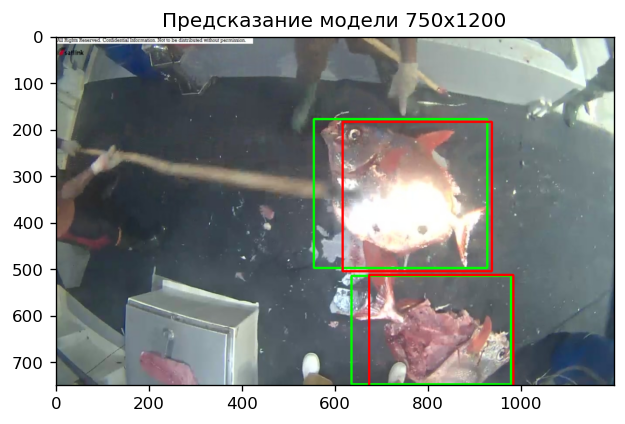

In [22]:
annotation = boxes['LAG'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.15)
decoded = non_max_suppression(decoded,
                              max_output_size=2,
                              iou_threshold=0.5)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

### Визуализируем предсказание на тесте

1/1 [==============================] - 0s 22ms/step


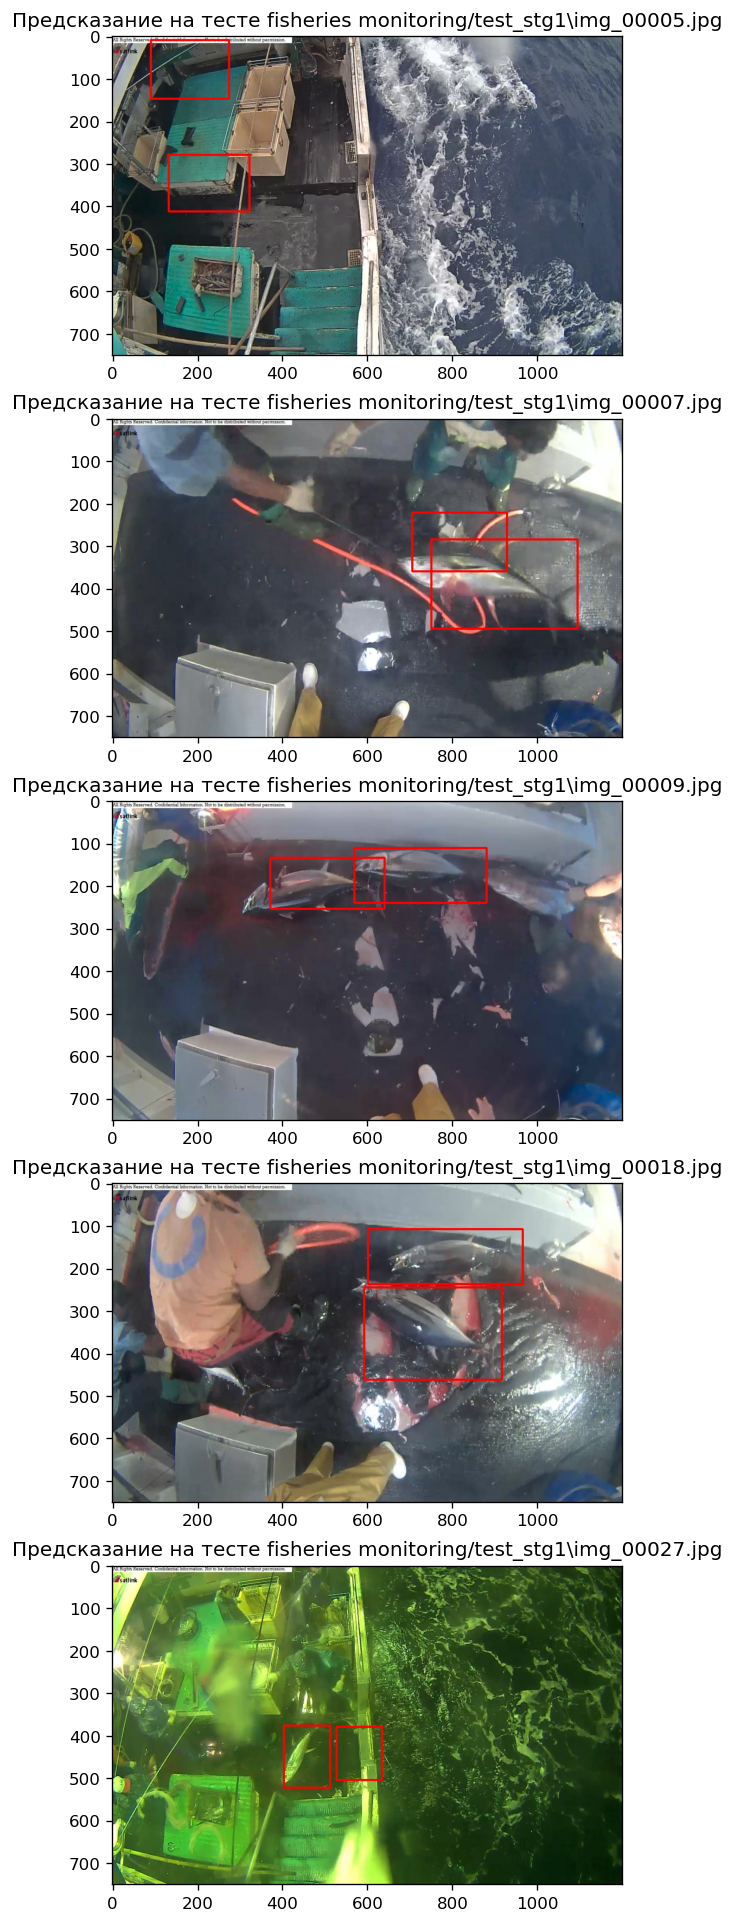

In [21]:
test_images = glob('fisheries monitoring/test_stg1/*.jpg')[:5]
plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

### Агрегация результатов

In [23]:
def predict_image(file, model):
    try:
        _, sample_img = load_img(file)
        pred = model.predict(np.array([sample_img]))[0]
        decoded = decode_prediction(pred, conf_thr=0.01)
        decoded = non_max_suppression(decoded, max_output_size=1, iou_threshold=0.5)
        return decoded
    except Exception as e:
        print(f'Error processing {file}: {str(e)}')
        return None

In [24]:
def construct_result_entry(file_name, decoded_predictions, no_fish_prob, other_fish_prob, correct_scale):
    if not decoded_predictions:
        probs = [correct_scale / 6] * 6
    else:
        probs = decoded_predictions[0]['labels'] * correct_scale

    result_entry = {
        'image': file_name,
        'ALB': probs[5],
        'BET': probs[1],
        'DOL': probs[4],
        'LAG': probs[3],
        'NoF': no_fish_prob,
        'OTHER': other_fish_prob,
        'SHARK': probs[0],
        'YFT': probs[2]
    }
    return result_entry

In [25]:
# Constants for fixed probabilities from sample submission
NO_FISH_PROB = 0.123081
OTHER_FISH_PROB = 0.079142
CORRECT_SCALE = 1.0 - (NO_FISH_PROB + OTHER_FISH_PROB)

In [26]:
result_data = []

In [30]:
# Process each image file
for file in glob('fisheries monitoring/test_stg2/*.jpg'):
    bn = os.path.basename(file)
    decoded = predict_image(file, model)
    entry = construct_result_entry(bn, decoded, NO_FISH_PROB, OTHER_FISH_PROB, CORRECT_SCALE)
    result_data.append(entry)

1/1 [==============================] - 0s 23ms/step


C:\Users\Pelia\AppData\Local\Temp\ipykernel_8652\1170955640.py:56: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


1/1 [==============================] - 0s 24ms/step


In [33]:
# Create DataFrame
result_table = pd.DataFrame(result_data)
result_table.to_csv('submission_stg2.csv', index=False)